In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from lazypredict.Supervised import LazyClassifier
from sklearn import metrics
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.optimizers import RMSprop,Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler

# READ & PROCESS DATA

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
all_data=[train_df,test_df]

data_names=['training data','testing data']

In [4]:
for data in all_data:
    data.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [5]:
filling_value=train_df['Arrival Delay in Minutes'].mean()

for data in all_data:
    data['Arrival Delay in Minutes'].fillna(f'{filling_value:.1f}',inplace=True)

In [6]:
#The column must be returned to float because when adding the average value, it was added as an string value 
for data in all_data:
    data['Arrival Delay in Minutes']=data['Arrival Delay in Minutes'].astype(float)

# QUESTION 4: OVERFIT REDUCE

In [7]:
to_categorical=['Gender','Customer Type','Type of Travel','Class','satisfaction']

L_encoder=LabelEncoder()
for label in to_categorical:
    train_df[label]=L_encoder.fit_transform(train_df[label])
    test_df[label]=L_encoder.fit_transform(test_df[label])

### 1) REMOVE OUTLIERS

In [8]:
Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Gender                                 1.00
Customer Type                          0.00
Age                                   24.00
Type of Travel                         1.00
Class                                  1.00
Flight Distance                     1329.00
Inflight wifi service                  2.00
Departure/Arrival time convenient      2.00
Ease of Online booking                 2.00
Gate location                          2.00
Food and drink                         2.00
Online boarding                        2.00
Seat comfort                           3.00
Inflight entertainment                 2.00
On-board service                       2.00
Leg room service                       2.00
Baggage handling                       2.00
Checkin service                        1.00
Inflight service                       2.00
Cleanliness                            2.00
Departure Delay in Minutes            12.00
Arrival Delay in Minutes              13.00
satisfaction                    

In [9]:
train = train_df[~((train_df < (Q1 - 1.5 * IQR)) |(train_df > (Q3 + 1.5 * IQR))).any(axis=1)]
train.shape

(61197, 23)

In [10]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(train)
#modified_data = pd.DataFrame(r_scaler.transform(train), index=train['id'], columns=train.columns)
modified_data = pd.DataFrame(r_scaler.transform(train), columns=train.columns)
modified_data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1.00,0.00,0.08,1.00,1.00,0.12,0.60,0.80,0.60,0.20,...,1.00,0.80,0.60,0.75,0.67,1.00,1.00,0.83,0.56,0.00
1,0.00,0.00,0.24,0.00,0.00,0.30,0.40,0.40,0.40,0.40,...,1.00,0.80,0.60,0.75,0.67,0.80,1.00,0.00,0.00,1.00
2,1.00,0.00,0.69,0.00,0.00,0.05,0.60,0.60,0.60,0.60,...,0.60,0.60,0.80,0.75,0.33,0.60,0.60,0.00,0.00,1.00
3,0.00,0.00,0.24,1.00,0.50,0.31,0.60,0.80,0.40,0.20,...,0.20,0.60,0.80,0.75,0.67,0.80,0.20,0.00,0.00,0.00
4,1.00,0.00,0.51,1.00,0.50,0.34,0.40,0.80,0.40,0.60,...,0.40,0.60,0.60,0.75,0.33,1.00,0.40,0.30,0.72,0.00


### 2) FEATURES SELECTION

In [11]:
X = modified_data.loc[:,modified_data.columns!='satisfaction']
y = modified_data[['satisfaction']]

selector = SelectKBest(chi2, k=10)
selector.fit(X, y)

X_filter_selection = selector.transform(X)

print(X.columns[selector.get_support(indices=True)])

Index(['Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Cleanliness'],
      dtype='object')


In [13]:
# X = train.drop('satisfaction', axis=1)
# y = train['satisfaction']

# selector = SelectFromModel(rf(n_estimators=100, random_state=0))
# selector.fit(X, y)

# support = selector.get_support()

# features = X.loc[:,support].columns.tolist()

# print(features)

['Type of Travel', 'Class', 'Inflight wifi service', 'Online boarding', 'Seat comfort', 'Inflight entertainment']


### 3) UNDERSAMPLING

In [12]:
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_filter_selection, y.values.ravel())

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.97,0.97,0.97,0.97,0.72
XGBClassifier,0.97,0.97,0.97,0.97,0.41
RandomForestClassifier,0.97,0.97,0.97,0.97,5.08
ExtraTreesClassifier,0.97,0.97,0.97,0.97,6.72
BaggingClassifier,0.97,0.97,0.97,0.97,2.38
SVC,0.96,0.96,0.96,0.96,26.82
DecisionTreeClassifier,0.95,0.95,0.95,0.95,0.60
AdaBoostClassifier,0.94,0.94,0.94,0.94,2.70
KNeighborsClassifier,0.94,0.94,0.94,0.94,3.79


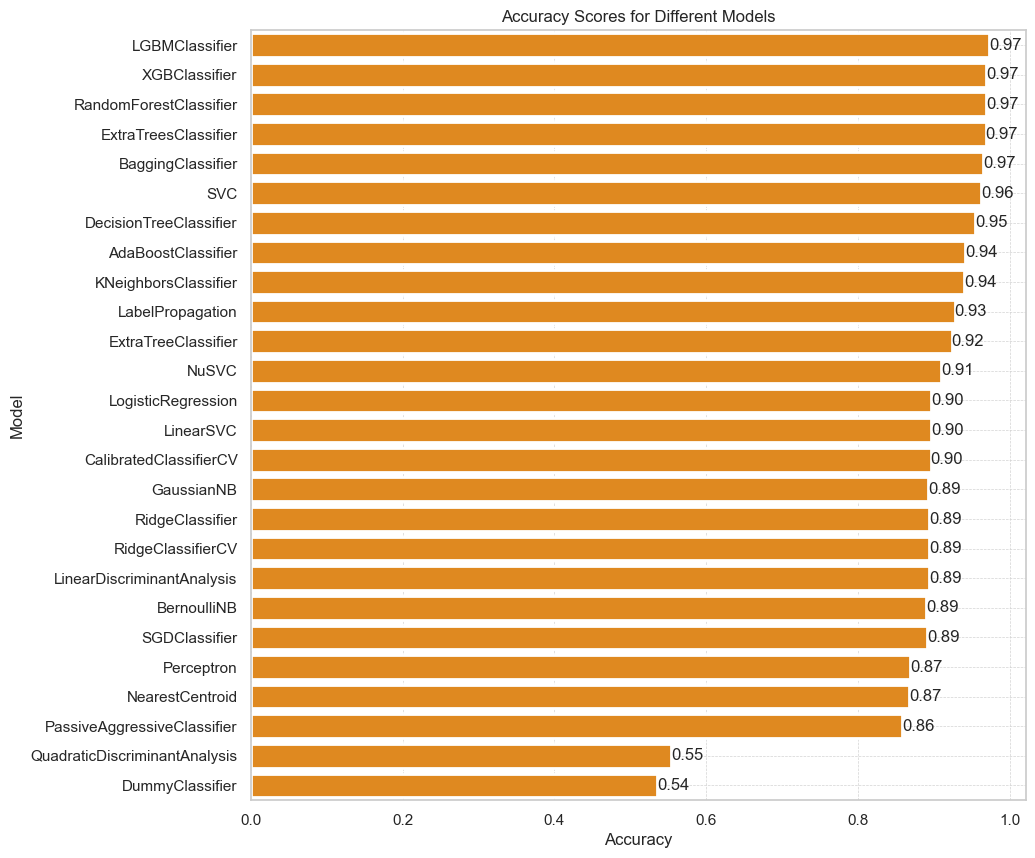

In [ ]:
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models.index, x="Accuracy", data=models, color='darkorange', linewidth=2)
plt.xticks()

for p in ax.patches:
    ax.annotate(f"{p.get_width():.2f}", (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center')

ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.title("Accuracy Scores for Different Models")
plt.show()

In [15]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = metrics.accuracy_score(yt, yp)
    precision, recall, f_beta, _ = metrics.precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

### 4) USING K-FOLD

In [20]:
XGB_hyper_params = {'max_depth': 5, 'n_estimators': 125, 'objective': 'binary:logistic', 'seed': 42}

hyper_XGB = XGBClassifier(**XGB_hyper_params)
hyper_XGB.fit(X_train, y_train)
get_accuracy(X_train, X_test, y_train, y_test, hyper_XGB)

{'test Accuracy': 0.9687577897798089, 'train Accuracy': 0.9775238886580806}

In [21]:
kf=KFold(n_splits=5)
cv_scores = cross_val_score(estimator= Pipeline(steps=[("model", XGBClassifier())]), X=X_train,y=y_train,cv=kf,scoring="accuracy")

for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1} score: {score:.5f}")

print("***" * 9)
print(f"Mean Accuracy Score : {cv_scores.mean():.5f}")

Fold 1 score: 0.96843
Fold 2 score: 0.96749
Fold 3 score: 0.96884
Fold 4 score: 0.96874
Fold 5 score: 0.96915
***************************
Mean Accuracy Score : 0.96853


### 5) L1 and L2 Regularization

### EXAMPLE FOR LINEAR SVM

In [27]:
svc_clf = LinearSVC(dual=False)
svc_clf.fit(X_train, y_train)
get_accuracy(X_train, X_test, y_train, y_test, svc_clf)

{'test Accuracy': 0.8899875363523058, 'train Accuracy': 0.8909638554216868}

In [29]:
hyper_svc_clf = LinearSVC(dual=False)

In [30]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]
}

In [31]:
grid_search = GridSearchCV(hyper_svc_clf, param_grid,scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train,y_train)
get_accuracy(X_train, X_test, y_train, y_test, grid_search)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'test Accuracy': 0.8899875363523058, 'train Accuracy': 0.8909223099293727}

In [32]:
grid_search.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [33]:
hyper_svc_params = {'C': 0.01, 'penalty': 'l2'}

hyper_svc = XGBClassifier(**hyper_svc_params)
hyper_svc.fit(X_train, y_train)
get_accuracy(X_train, X_test, y_train, y_test, hyper_svc)

{'test Accuracy': 0.9687577897798089, 'train Accuracy': 0.9775238886580806}

In [34]:
err_train = np.mean(y_train != hyper_svc.predict(X_train))
err_test  = np.mean(y_test  != hyper_svc.predict(X_test))

In [35]:
print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.022476111341919403
Error on the test sample:  0.031242210220191108


## IN NEURAL NETWORK (HAVE DONE IN FILE QUESTION 1_2_3)
### 6) ADD DROPOUT LAYER 
### 7) ADD EARLY STOPPING

# QUESTION 5: IMPROVE ACCURACY

### 1) TRY IN OTHERS MODELS TO FIND THE MOST SUITABLE MODELS

### 2) HYPER PARAMETERS TUNING 

### 3) TRACK METRICS (ACCURACY, PRECISION, RECALL, F1-SCORE)

### 4) USING CROSS-VALIDATION

### 5) USING ENSEMBLE MODELS